In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os

# --- Configuration ---
CSV_FILE_PATH = 'consolidated_results.csv'
OUTPUT_DIR = 'analysis_plots_tables'
SIGNIFICANCE_THRESHOLD = 0.05

# Create output directory if it doesn't exist
os.makedirs(OUTPUT_DIR, exist_ok=True)

In [2]:
# --- Helper Functions ---

def map_conceptual_group(row):
    """Maps specific user groups from different notions to conceptual groups."""
    pop_notion = row['popularity_notion']
    user_group = row['user_group']

    if pop_notion in ['pop_one', 'pop_two']:
        if user_group == 'low':
            return 'Niche-Oriented'
        elif user_group == 'med':
            return 'Diverse'
        elif user_group == 'high':
            return 'Blockbuster-Oriented'
    elif pop_notion == 'pop_four':
        if user_group == 'high': # High niche consumption rate -> Niche-Oriented
            return 'Niche-Oriented'
        elif user_group == 'med':
            return 'Diverse'
        elif user_group == 'low': # Low niche consumption rate -> Blockbuster-Oriented
            return 'Blockbuster-Oriented'
    return 'Unknown' # Should not happen with valid data

def map_descriptive_names(df):
    """Maps codes to more descriptive names for plots."""
    strategy_map = {
        'eva_two': 'UserTest',
        'eva_three': 'TrainItems'
    }
    notion_map = {
        'pop_one': 'PopularPercentage',
        'pop_two': 'AveragePopularity',
        'pop_four': 'NicheConsumptionRate'
    }
    df['eval_strategy_desc'] = df['evaluation_strategy'].map(strategy_map)
    df['pop_notion_desc'] = df['popularity_notion'].map(notion_map)
    return df

def highlight_significant(val):
    """Highlights p-values below the significance threshold."""
    if pd.isna(val):
        return ''
    color = 'red' if val < SIGNIFICANCE_THRESHOLD else 'black'
    return f'color: {color}'

def plot_faceted_grouped_bar(data, y_metric, title_prefix, filename_prefix):
    """Generates faceted grouped bar charts (Metric by User Group within each notion/strategy)."""
    g = sns.catplot(
        data=data,
        x='algorithm',
        y=y_metric,
        hue='user_group',
        col='eval_strategy_desc',
        row='pop_notion_desc',
        kind='bar',
        sharey=False, # Allow different y-axis scales
        aspect=1.5,
        height=4,
        palette='viridis',
        order=sorted(data['algorithm'].unique()), # Consistent algorithm order
        hue_order=['low', 'med', 'high'] # Consistent group order
    )
    g.fig.suptitle(f'{title_prefix}: {y_metric} by User Group (Facets: Pop Notion / Eval Strategy)', y=1.03)
    g.set_axis_labels("Algorithm", y_metric)
    g.set_titles(row_template="{row_name}", col_template="{col_name}")
    g.tick_params(axis='x', rotation=45)
    plt.tight_layout(rect=[0, 0, 1, 1]) # Adjust layout
    plt.savefig(os.path.join(OUTPUT_DIR, f'{filename_prefix}_{y_metric}_faceted.png'), bbox_inches='tight')
    plt.show() # Display in notebook
    plt.close()

def plot_comparative_grouped_bar(data, y_metric, title_prefix, filename_prefix):
    """Generates comparative grouped bar charts (Metric by Pop Notion for each conceptual group)."""
    conceptual_groups = ['Niche-Oriented', 'Diverse', 'Blockbuster-Oriented']
    for concept_group in conceptual_groups:
        df_filtered = data[data['conceptual_group'] == concept_group].copy()
        if df_filtered.empty:
            print(f"Skipping comparative plot for {concept_group} - no data.")
            continue

        g = sns.catplot(
            data=df_filtered,
            x='algorithm',
            y=y_metric,
            hue='pop_notion_desc', # Compare the grouping methods
            col='eval_strategy_desc',
            row='domain',
            kind='bar',
            sharey=False,
            aspect=1.5,
            height=4,
            palette='magma',
            order=sorted(df_filtered['algorithm'].unique()), # Consistent algorithm order
            hue_order=sorted(df_filtered['pop_notion_desc'].unique()) # Consistent notion order
        )
        g.fig.suptitle(f'{title_prefix}: {y_metric} Comparison for {concept_group} Users', y=1.03)
        g.set_axis_labels("Algorithm", y_metric)
        g.set_titles(row_template="{row_name}", col_template="{col_name}")
        g.tick_params(axis='x', rotation=45)
        plt.tight_layout(rect=[0, 0, 1, 1])
        plt.savefig(os.path.join(OUTPUT_DIR, f'{filename_prefix}_{y_metric}_compare_{concept_group}.png'), bbox_inches='tight')
        plt.show() # Display in notebook
        plt.close()

def create_summary_table(data, metric_value_col, filename):
    """Creates and saves a pivot table summarizing the metric."""
    try:
        pivot = pd.pivot_table(
            data,
            index='algorithm',
            columns=['domain', 'eval_strategy_desc', 'pop_notion_desc', 'user_group'],
            values=metric_value_col
        )
        print(f"\n--- Summary Table: {metric_value_col} ---")
        display(pivot.style.format("{:.3f}").background_gradient(cmap='viridis', axis=None)) # Display with formatting in notebook
        pivot.to_csv(os.path.join(OUTPUT_DIR, filename))
        print(f"Saved table to {os.path.join(OUTPUT_DIR, filename)}")
        return pivot
    except Exception as e:
        print(f"Error creating pivot table for {metric_value_col}: {e}")
        return None

def create_ttest_table(data, filename):
    """Creates and saves a pivot table for T-test p-values."""
    try:
        pivot = pd.pivot_table(
            data,
            index='algorithm',
            columns=['domain', 'eval_strategy_desc', 'pop_notion_desc', 'comparison_group'],
            values='p_value'
        )
        print(f"\n--- T-Test p-value Table: {data['metric_type'].iloc[0].replace('_TTEST','')} ---")
        display(pivot.style.format("{:.4f}").applymap(highlight_significant)) # Highlight significant values in notebook
        pivot.to_csv(os.path.join(OUTPUT_DIR, filename))
        print(f"Saved table to {os.path.join(OUTPUT_DIR, filename)}")
        return pivot
    except Exception as e:
        print(f"Error creating T-test pivot table: {e}")
        return None

## Main Analysis Script

In [3]:
# 1. Load Data
print(f"Loading data from {CSV_FILE_PATH}...")
try:
    df = pd.read_csv(CSV_FILE_PATH)
    print(f"Successfully loaded {len(df)} rows.")
    # Optional: Display first few rows to check
    # display(df.head())
except FileNotFoundError:
    print(f"Error: CSV file not found at {CSV_FILE_PATH}")
    # In a notebook, we might not want to exit immediately
    # exit()
    df = None # Set df to None if file not found
except Exception as e:
    print(f"An error occurred loading the CSV: {e}")
    df = None

Loading data from consolidated_results.csv...
Successfully loaded 864 rows.


In [4]:
# 2. Preprocess Data
if df is not None:
    print("Preprocessing data...")
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['p_value'] = pd.to_numeric(df['p_value'], errors='coerce')

    # Apply descriptive names
    df = map_descriptive_names(df)

    # Add conceptual group mapping
    df['conceptual_group'] = df.apply(map_conceptual_group, axis=1)

    # Separate DataFrames for metrics and t-tests
    df_gap = df[df['metric_type'] == 'GAP'].copy()
    df_ndcg = df[df['metric_type'] == 'NDCG'].copy()
    df_gap_ttest = df[df['metric_type'] == 'GAP_TTEST'].copy()
    df_ndcg_ttest = df[df['metric_type'] == 'NDCG_TTEST'].copy()
    print("Preprocessing complete.")
    # Optional: Display info or head of processed dataframes
    # display(df_gap.head())
    # display(df_ndcg.head())
else:
    print("Skipping preprocessing because data failed to load.")

Preprocessing data...
Preprocessing complete.


## 3. Generate %ΔGAP Analysis


--- Generating %ΔGAP Faceted Plots ---
Plotting Faceted %ΔGAP for domain: music


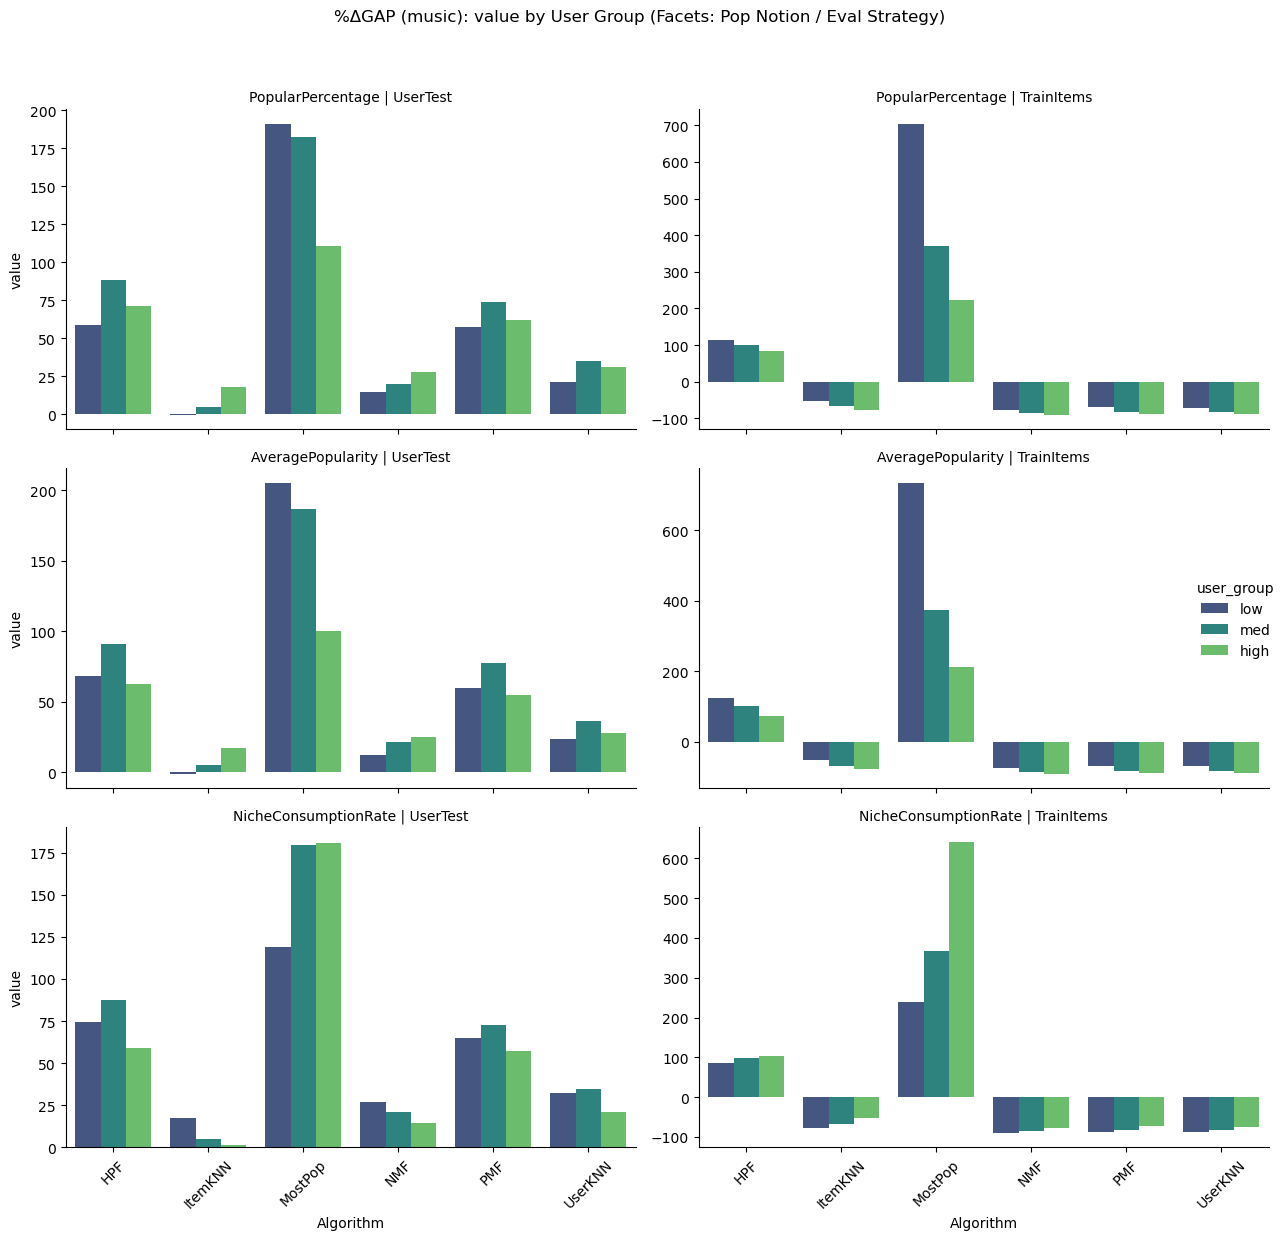

Plotting Faceted %ΔGAP for domain: movies


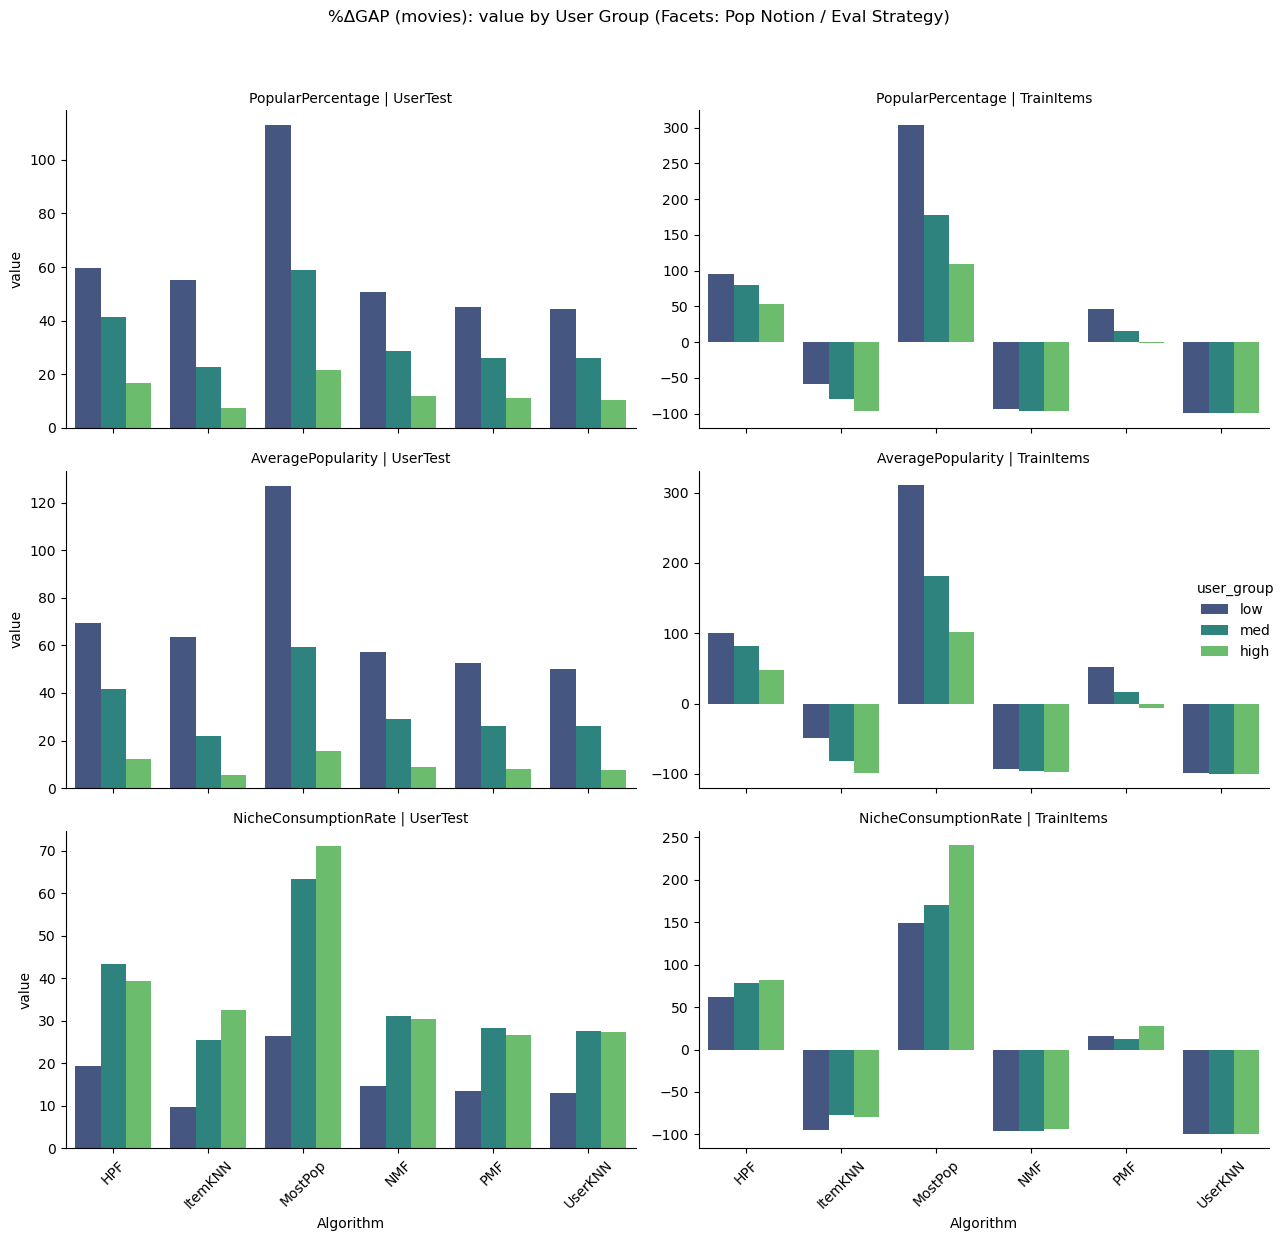

In [5]:
# 3a. Faceted Bar Chart (%ΔGAP by User Group within notion/strategy)
if 'df_gap' in locals() and not df_gap.empty:
    print("\n--- Generating %ΔGAP Faceted Plots ---")
    for domain in df_gap['domain'].unique():
        print(f"Plotting Faceted %ΔGAP for domain: {domain}")
        plot_faceted_grouped_bar(
            df_gap[df_gap['domain'] == domain],
            'value',
            f'%ΔGAP ({domain})',
            f'{domain}_gap'
        )
else:
    print("Skipping %ΔGAP Faceted Plots - data not available.")


--- Generating Comparative %ΔGAP Plots ---
Plotting Comparative %ΔGAP by Popularity Notion...


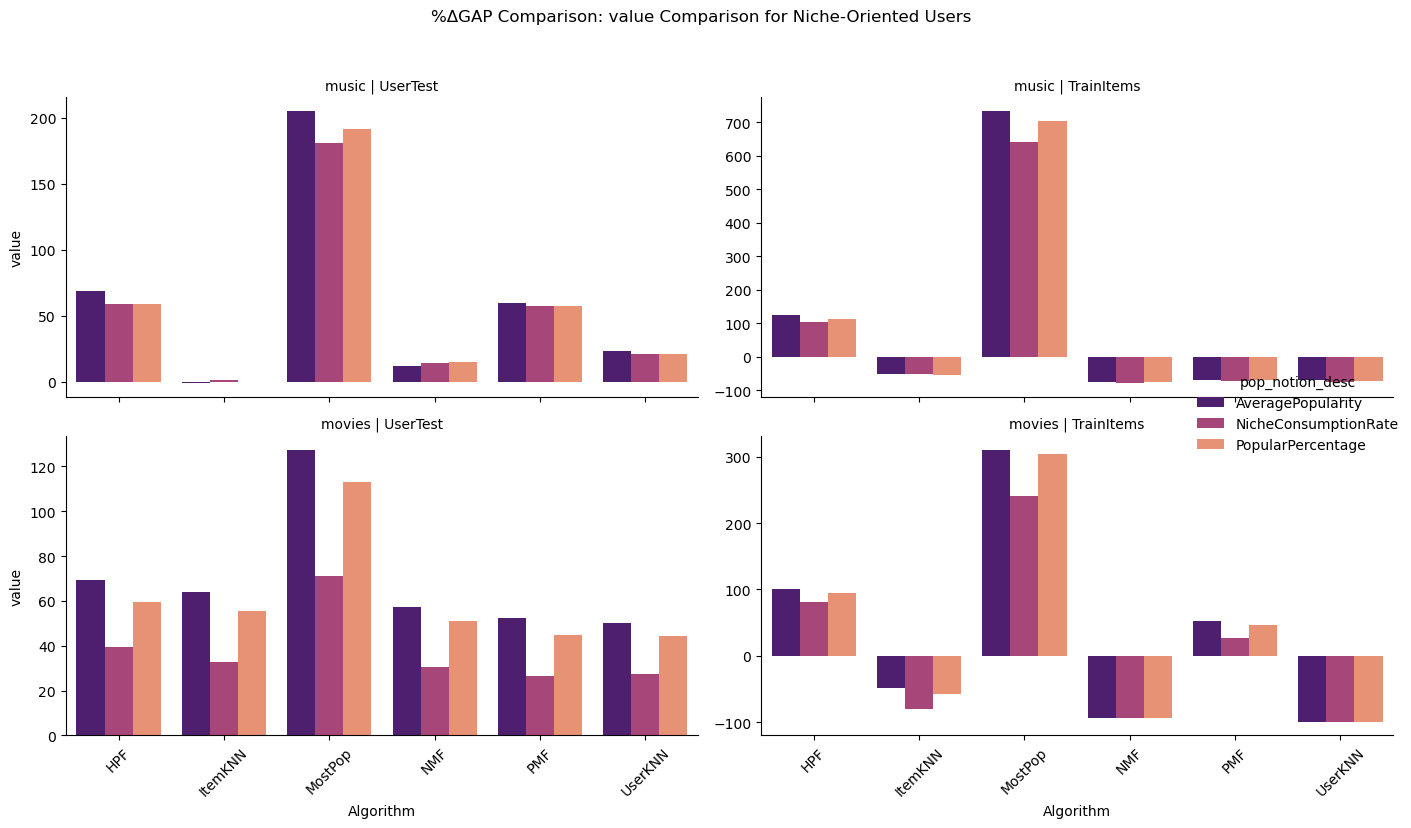

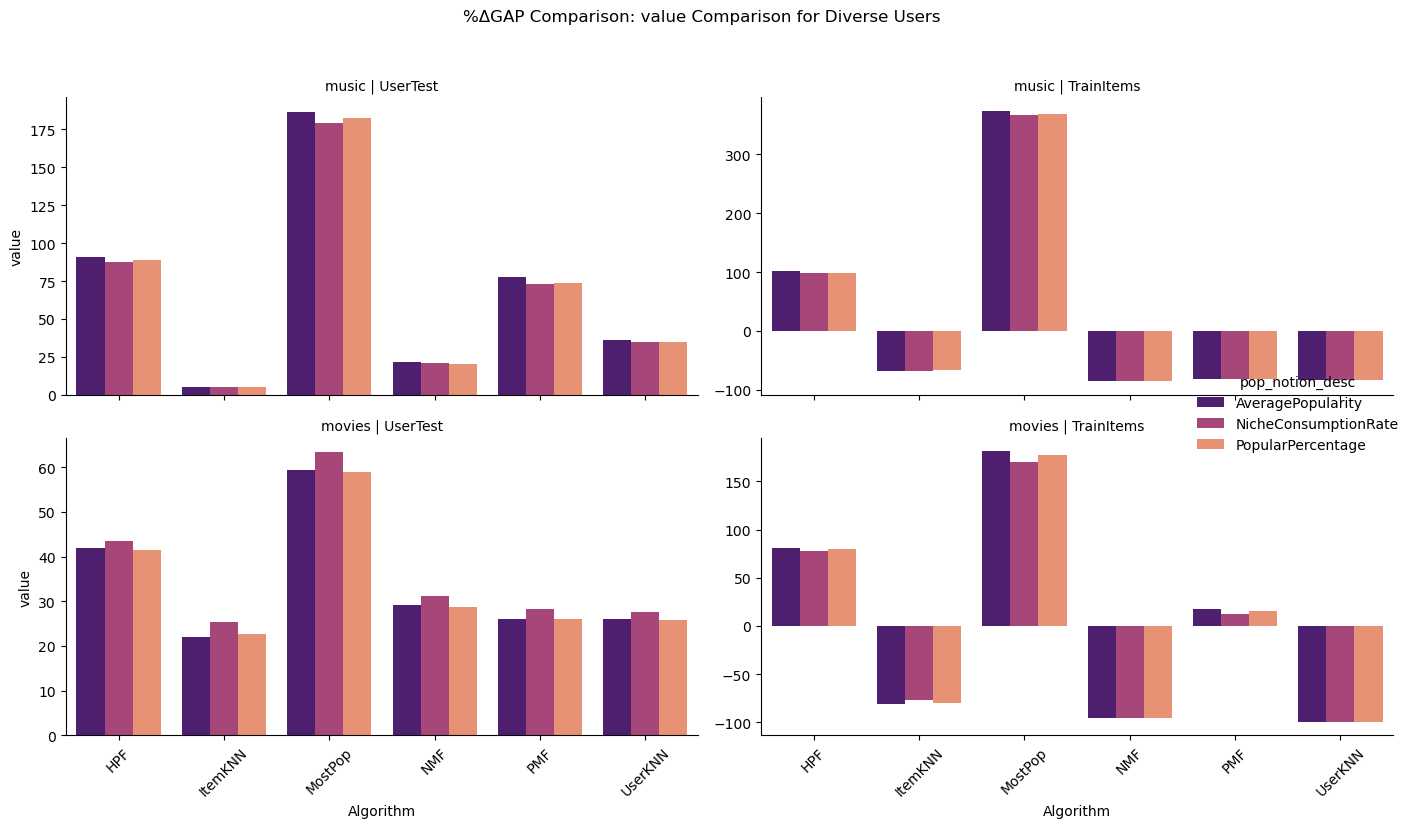

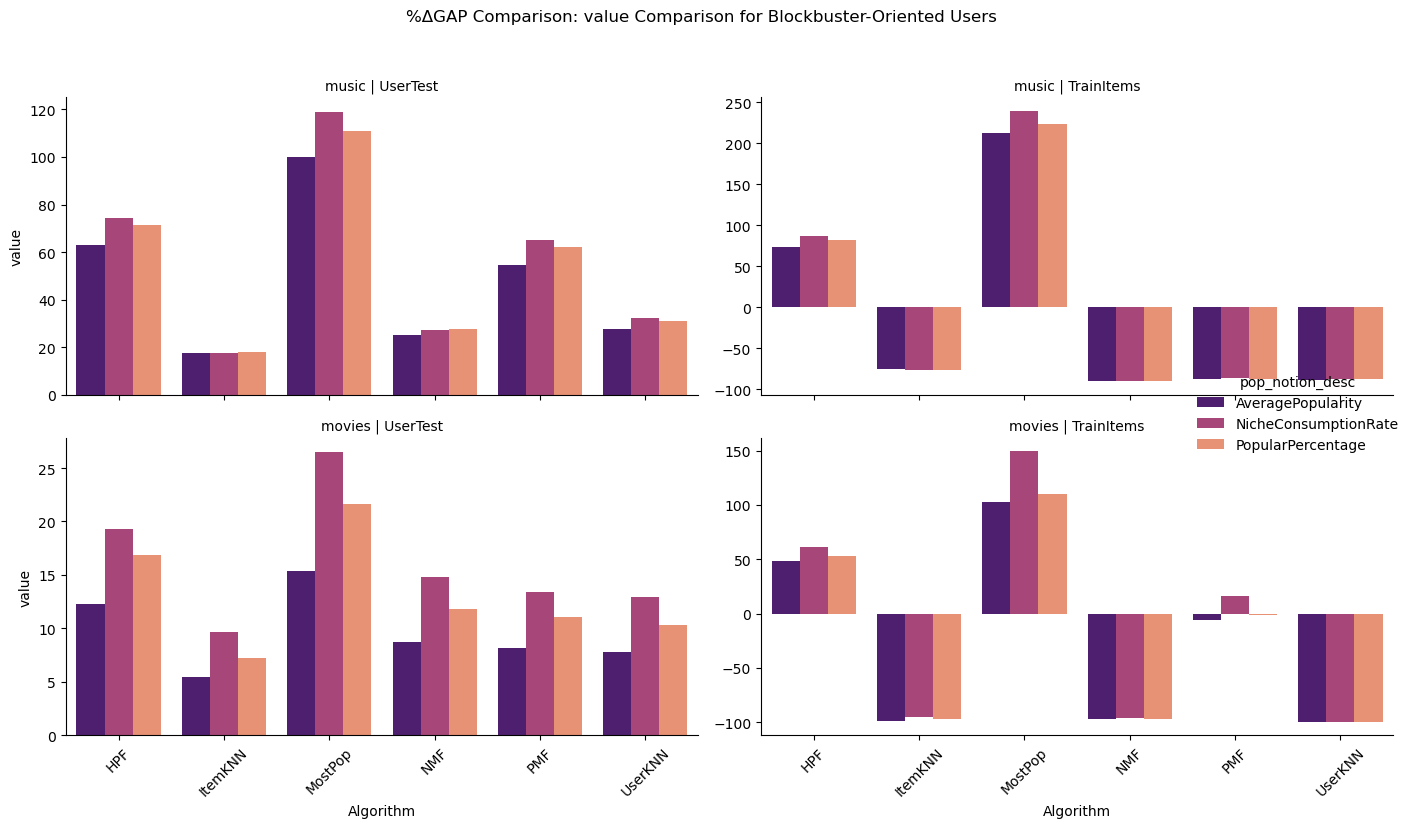

In [6]:
# 3b. Comparative Bar Chart (%ΔGAP by Pop Notion for conceptual groups)
if 'df_gap' in locals() and not df_gap.empty:
    print("\n--- Generating Comparative %ΔGAP Plots ---")
    print("Plotting Comparative %ΔGAP by Popularity Notion...")
    plot_comparative_grouped_bar(
        df_gap,
        'value',
        '%ΔGAP Comparison',
        'gap_compare'
    )
else:
     print("Skipping Comparative %ΔGAP Plots - data not available.")

In [7]:
# 3c. Summary Table (%ΔGAP)
if 'df_gap' in locals() and not df_gap.empty:
    print("\n--- Generating %ΔGAP Summary Table ---")
    gap_summary_table = create_summary_table(df_gap, 'value', 'summary_table_gap.csv')
else:
    print("Skipping %ΔGAP Summary Table - data not available.")
    gap_summary_table = None


--- Generating %ΔGAP Summary Table ---

--- Summary Table: value ---


Saved table to analysis_plots_tables\summary_table_gap.csv


In [8]:
# 3d. T-test Table (%ΔGAP)
if 'df_gap_ttest' in locals() and not df_gap_ttest.empty:
    print("\n--- Generating %ΔGAP T-test Table ---")
    gap_ttest_table = create_ttest_table(df_gap_ttest, 'ttest_table_gap.csv')
else:
    print("Skipping %ΔGAP T-test Table - data not available.")
    gap_ttest_table = None


--- Generating %ΔGAP T-test Table ---

--- T-Test p-value Table: GAP ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_22016\992557199.py:133: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot.style.format("{:.4f}").applymap(highlight_significant)) # Highlight significant values in notebook


Saved table to analysis_plots_tables\ttest_table_gap.csv


## 4. Generate NDCG@10 Analysis


--- Generating NDCG@10 Faceted Plots ---
Plotting Faceted NDCG@10 for domain: music


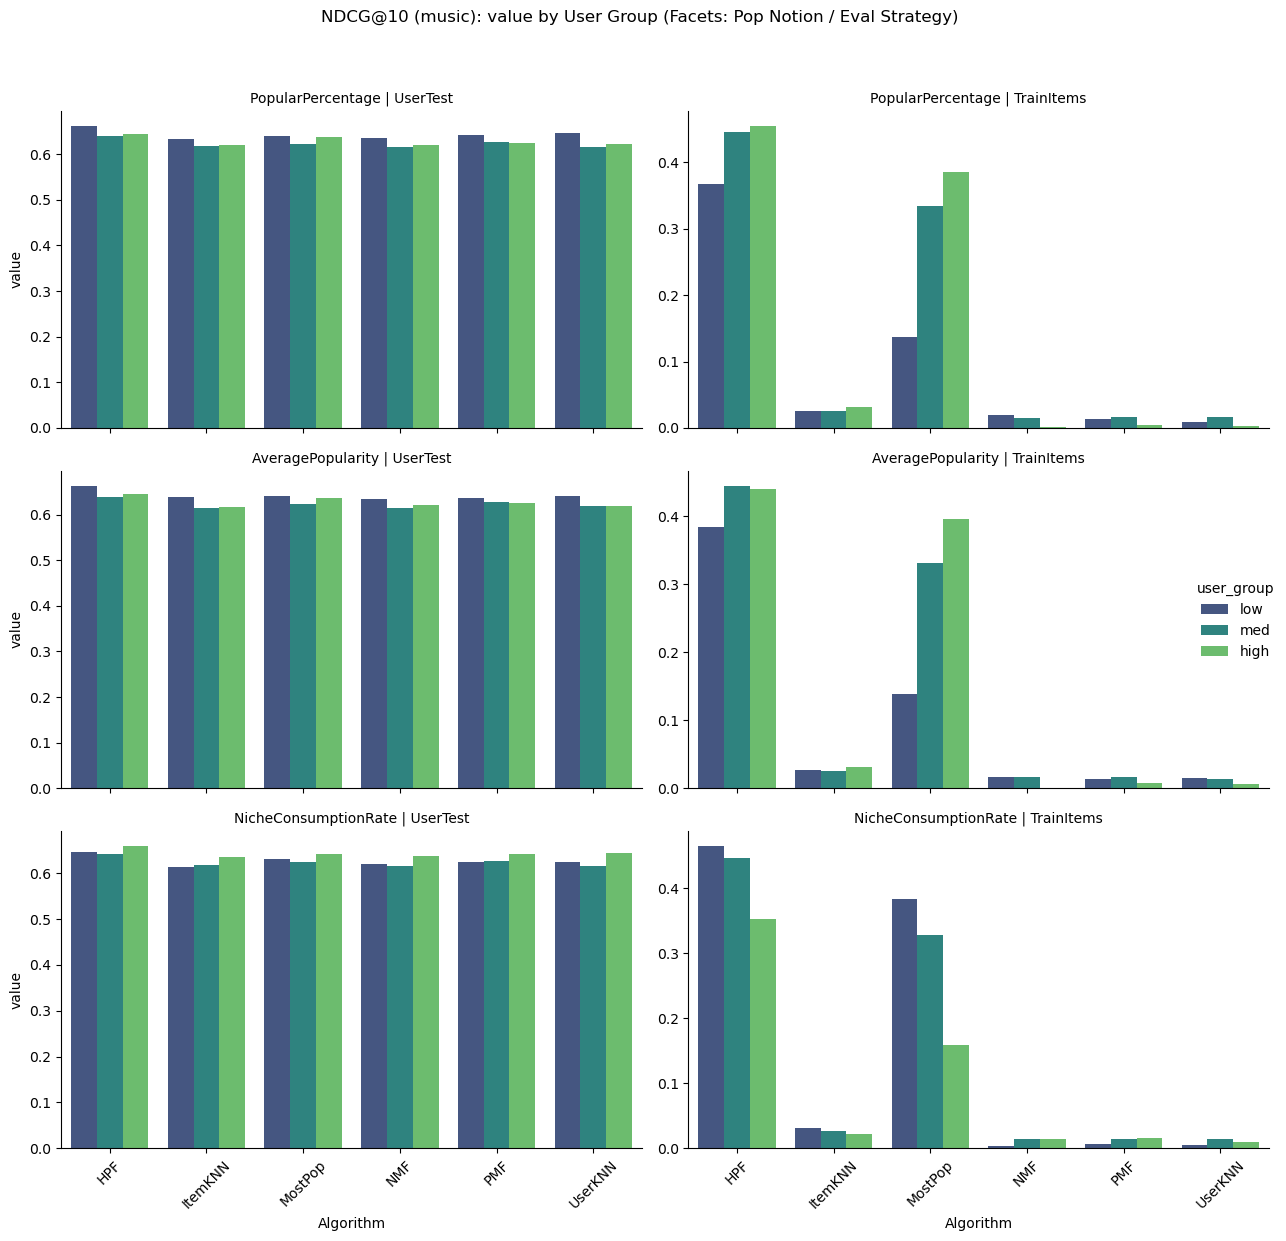

Plotting Faceted NDCG@10 for domain: movies


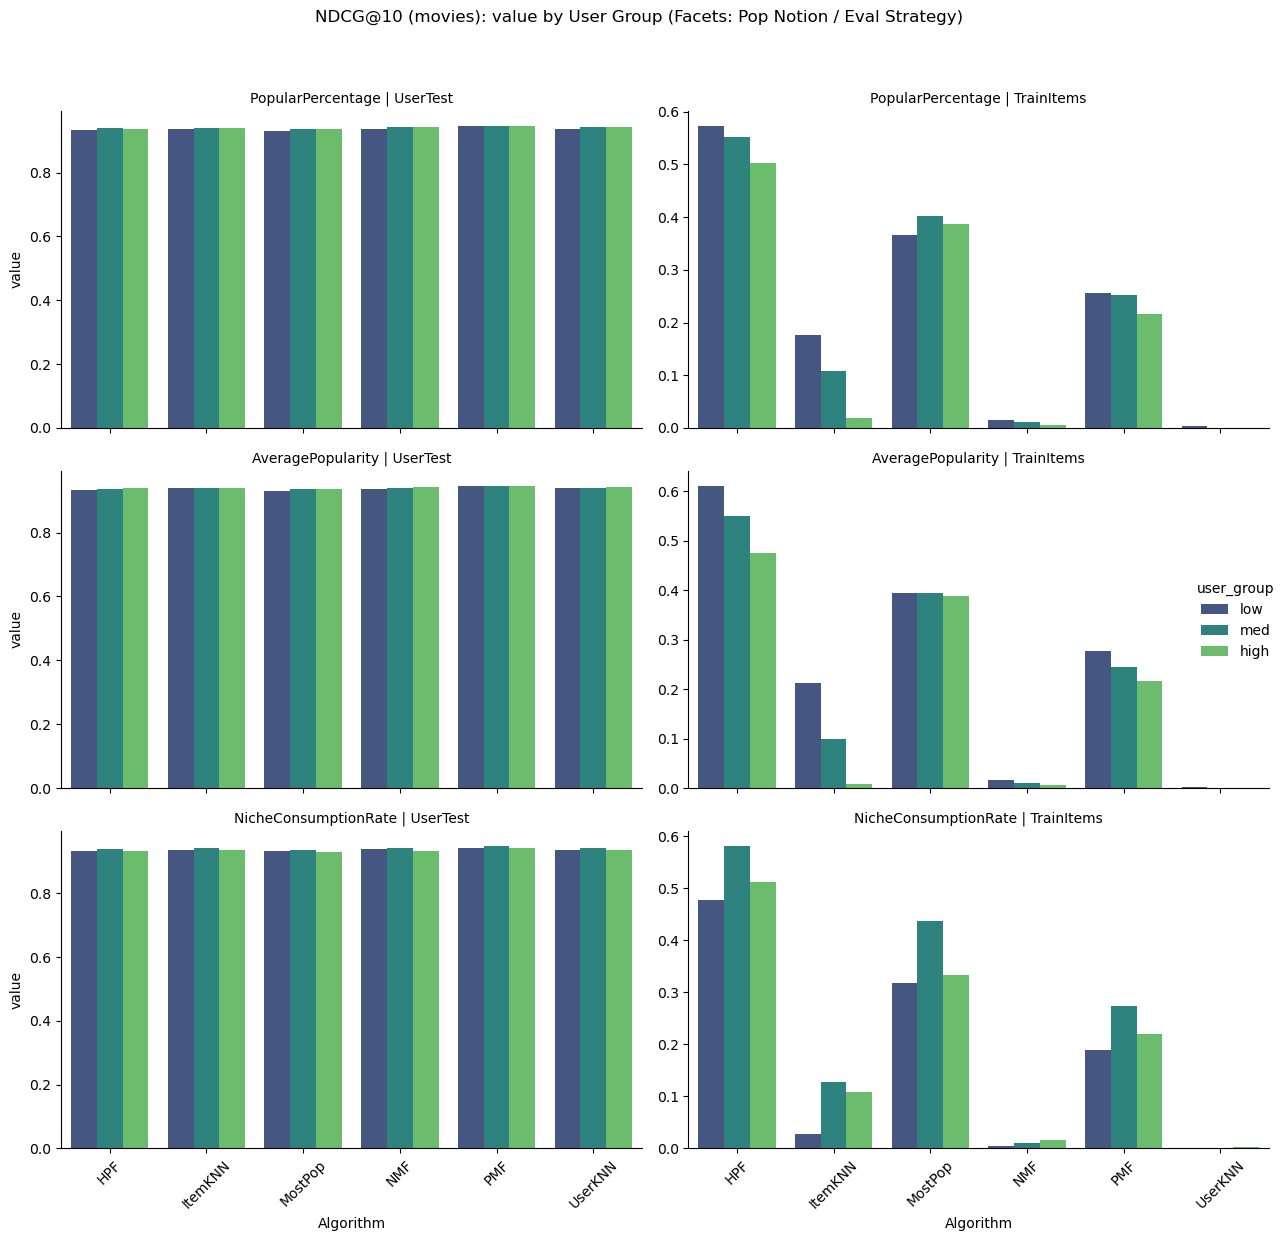

In [9]:
# 4a. Faceted Bar Chart (NDCG by User Group within notion/strategy)
if 'df_ndcg' in locals() and not df_ndcg.empty:
    print("\n--- Generating NDCG@10 Faceted Plots ---")
    for domain in df_ndcg['domain'].unique():
        print(f"Plotting Faceted NDCG@10 for domain: {domain}")
        plot_faceted_grouped_bar(
            df_ndcg[df_ndcg['domain'] == domain],
            'value',
            f'NDCG@10 ({domain})',
            f'{domain}_ndcg'
        )
else:
    print("Skipping NDCG@10 Faceted Plots - data not available.")


--- Generating Comparative NDCG@10 Plots ---
Plotting Comparative NDCG@10 by Popularity Notion...


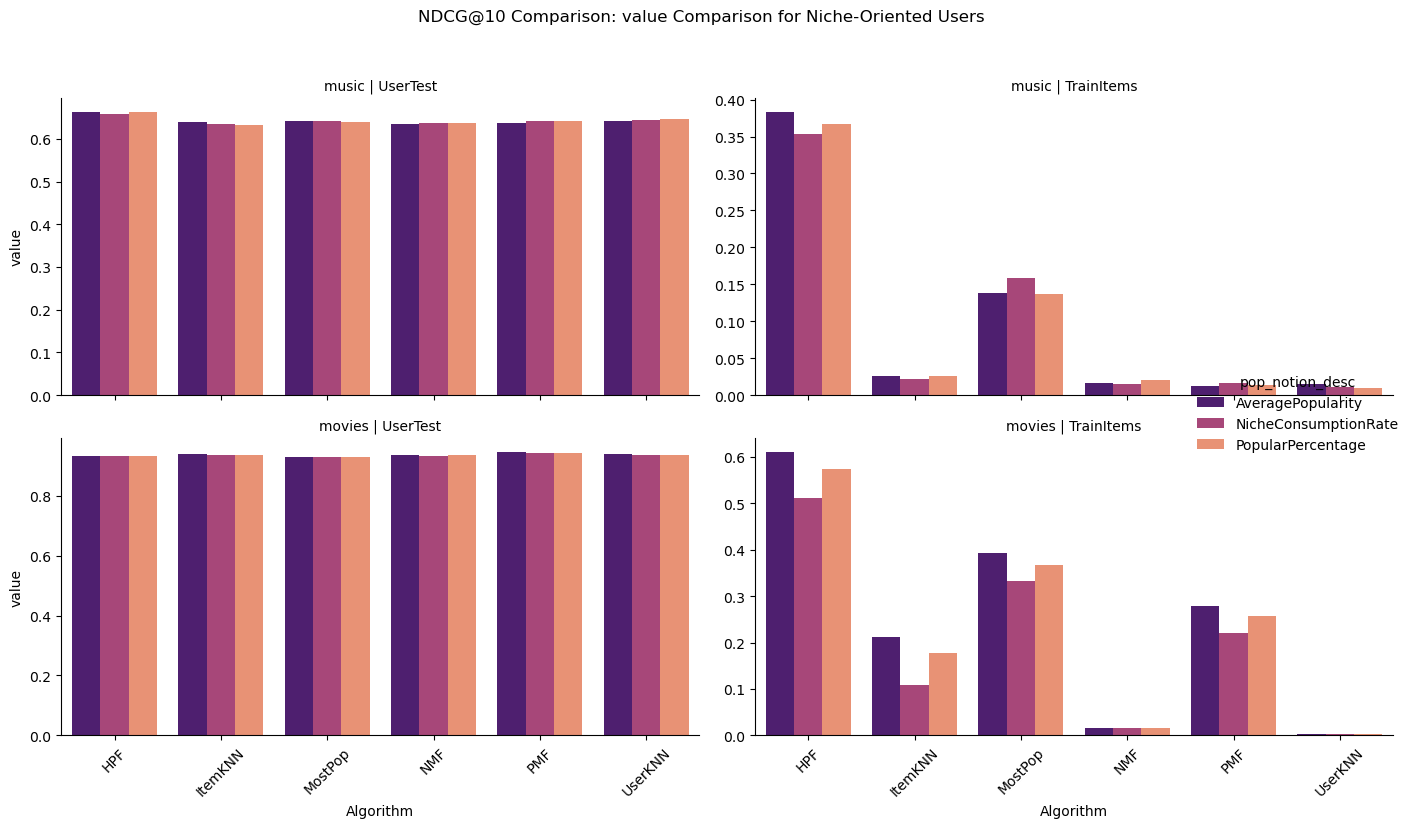

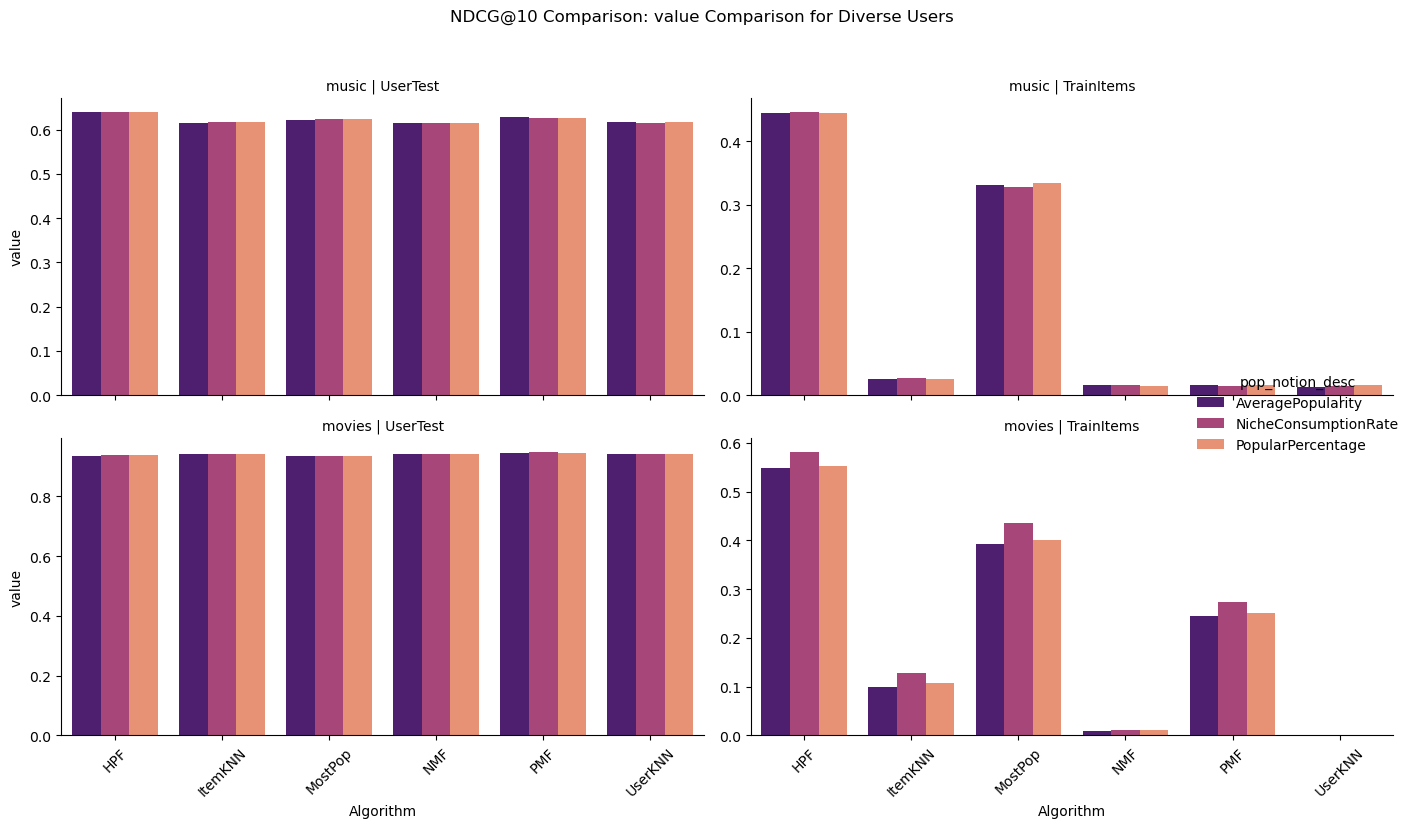

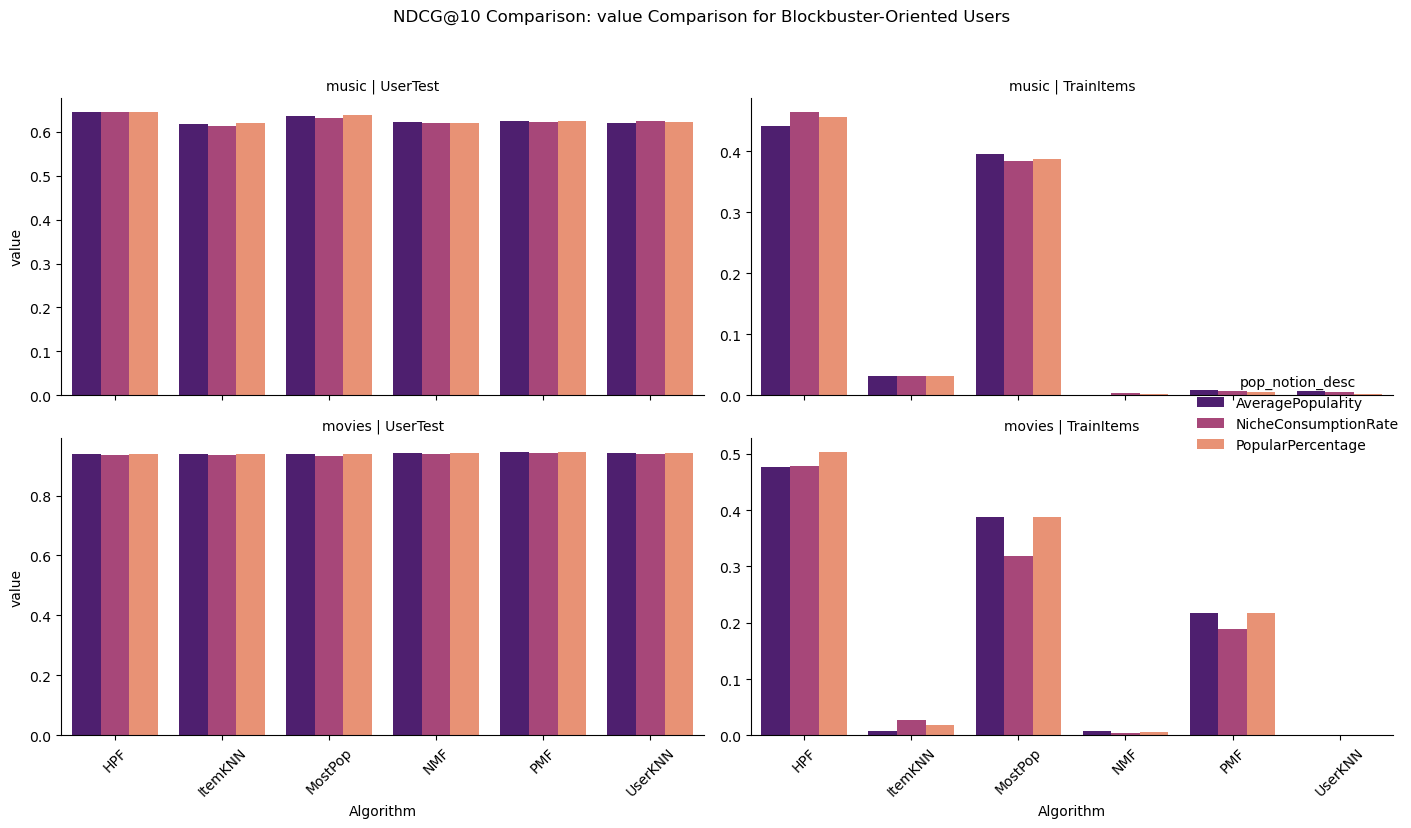

In [10]:
# 4b. Comparative Bar Chart (NDCG by Pop Notion for conceptual groups)
if 'df_ndcg' in locals() and not df_ndcg.empty:
    print("\n--- Generating Comparative NDCG@10 Plots ---")
    print("Plotting Comparative NDCG@10 by Popularity Notion...")
    plot_comparative_grouped_bar(
        df_ndcg,
        'value',
        'NDCG@10 Comparison',
        'ndcg_compare'
    )
else:
    print("Skipping Comparative NDCG@10 Plots - data not available.")

In [11]:
# 4c. Summary Table (NDCG)
if 'df_ndcg' in locals() and not df_ndcg.empty:
    print("\n--- Generating NDCG@10 Summary Table ---")
    ndcg_summary_table = create_summary_table(df_ndcg, 'value', 'summary_table_ndcg.csv')
else:
    print("Skipping NDCG@10 Summary Table - data not available.")
    ndcg_summary_table = None


--- Generating NDCG@10 Summary Table ---

--- Summary Table: value ---


Saved table to analysis_plots_tables\summary_table_ndcg.csv


In [12]:
# 4d. T-test Table (NDCG)
if 'df_ndcg_ttest' in locals() and not df_ndcg_ttest.empty:
    print("\n--- Generating NDCG@10 T-test Table ---")
    ndcg_ttest_table = create_ttest_table(df_ndcg_ttest, 'ttest_table_ndcg.csv')
else:
    print("Skipping NDCG@10 T-test Table - data not available.")
    ndcg_ttest_table = None


--- Generating NDCG@10 T-test Table ---

--- T-Test p-value Table: NDCG ---


C:\Users\Shreyash\AppData\Local\Temp\ipykernel_22016\992557199.py:133: FutureWarning: Styler.applymap has been deprecated. Use Styler.map instead.
  display(pivot.style.format("{:.4f}").applymap(highlight_significant)) # Highlight significant values in notebook


Saved table to analysis_plots_tables\ttest_table_ndcg.csv


## (Optional) Heatmaps

In [13]:
# --- (Optional) Heatmaps ---
print("\n--- Generating Optional Heatmaps ---")
# This requires looping through combinations and creating pivot tables first
if df is not None:
    for domain in df['domain'].unique():
        for strategy in df['eval_strategy_desc'].unique():
            for notion in df['pop_notion_desc'].unique():
                # Filter data for the current combination
                if 'df_gap' in locals() and not df_gap.empty:
                    df_subset_gap = df_gap[(df_gap['domain'] == domain) &
                                           (df_gap['eval_strategy_desc'] == strategy) &
                                           (df_gap['pop_notion_desc'] == notion)]
                else:
                    df_subset_gap = pd.DataFrame() # Empty dataframe

                if 'df_ndcg' in locals() and not df_ndcg.empty:
                     df_subset_ndcg = df_ndcg[(df_ndcg['domain'] == domain) &
                                            (df_ndcg['eval_strategy_desc'] == strategy) &
                                            (df_ndcg['pop_notion_desc'] == notion)]
                else:
                     df_subset_ndcg = pd.DataFrame()

                if not df_subset_gap.empty:
                    try:
                        pivot_gap = df_subset_gap.pivot_table(index='algorithm', columns='user_group', values='value')
                        plt.figure(figsize=(10, 6))
                        sns.heatmap(pivot_gap, annot=True, fmt=".1f", cmap="coolwarm", linewidths=.5)
                        plt.title(f'%ΔGAP Heatmap: {domain} / {strategy} / {notion}')
                        plt.tight_layout()
                        plt.savefig(os.path.join(OUTPUT_DIR, f'heatmap_gap_{domain}_{strategy.replace(" ","")}_{notion.replace(" ","")}.png'))
                        #plt.show() # Use display(fig) or just let it render
                        plt.close()
                    except Exception as e:
                        print(f"Could not generate GAP heatmap for {domain}/{strategy}/{notion}: {e}")

                if not df_subset_ndcg.empty:
                    try:
                        pivot_ndcg = df_subset_ndcg.pivot_table(index='algorithm', columns='user_group', values='value')
                        plt.figure(figsize=(10, 6))
                        sns.heatmap(pivot_ndcg, annot=True, fmt=".3f", cmap="viridis", linewidths=.5)
                        plt.title(f'NDCG@10 Heatmap: {domain} / {strategy} / {notion}')
                        plt.tight_layout()
                        plt.savefig(os.path.join(OUTPUT_DIR, f'heatmap_ndcg_{domain}_{strategy.replace(" ","")}_{notion.replace(" ","")}.png'))
                        #plt.show()
                        plt.close()
                    except Exception as e:
                        print(f"Could not generate NDCG heatmap for {domain}/{strategy}/{notion}: {e}")
else:
    print("Skipping Optional Heatmaps - data not available.")


--- Generating Optional Heatmaps ---


In [14]:
print(f"\n--- Analysis Complete. Plots and tables saved to '{OUTPUT_DIR}' directory. ---")


--- Analysis Complete. Plots and tables saved to 'analysis_plots_tables' directory. ---
